<a href="https://colab.research.google.com/github/nikoczernin/neural_network_implementation/blob/main/Exercise3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import hashlib
import requests
import tarfile
from datetime import datetime

from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from keras.applications import MobileNetV2

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, f1_score

from skimage import feature

In [ ]:

def download_dataset(url, download_dir, md5_checksum=None):
    # Create download directory if it doesn't exist
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)

    # Extract file name from URL
    filename = os.path.basename(url)

    # Download the file
    filepath = os.path.join(download_dir, filename)
    if not os.path.exists(filepath):
        print("Downloading", filename)
        response = requests.get(url, stream=True)
        with open(filepath, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
    else:
        print("File", filename, "already exists.")

    if md5_checksum is not None:
      # Verify MD5 checksum
      with open(filepath, 'rb') as f:
          md5 = hashlib.md5()
          while chunk := f.read(4096):
              md5.update(chunk)
      if md5.hexdigest() != md5_checksum:
          print("MD5 checksum verification failed!")
          return None

    return filepath


def extract_tar_gz(tar_gz_file, extract_dir):
    # Extract the tar.gz file
    print("Extracting", tar_gz_file)
    with tarfile.open(tar_gz_file, 'r:gz') as tar:
        tar.extractall(path=extract_dir)
    print("Extraction complete.")




In [ ]:
# function for displaying an image
def show(img):
  plt.imshow(img)
  plt.show()

# Data preparation


## Labeled Faces in the Wild
https://vis-www.cs.umass.edu/lfw/  
Download: http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [ ]:

# Download the labeled faces in the wild
url = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
md5_checksum = "a17d05bd522c52d84eca14327a23d494"
download_dir = "./data"
extract_dir = "./data"

# Download the dataset
dataset_filepath = download_dataset(url, download_dir, md5_checksum)

# Extract the dataset
if dataset_filepath:
    extract_tar_gz(dataset_filepath, extract_dir)




Extracting ./data/lfw.tgz
Extraction complete.


In [ ]:
# now, in the folder "./data/lfw/" are dozens of directories
# the dirs are labelled the name of the people who's photos they contain
faces_location = "data/lfw"

# out of the 5749 people, only 1680 have two or more images
# we will only use those 1680 people's images
min_number_of_images = 2

faces_x_paths = [] # list/array of faces' image paths
faces_y = [] # list/array of faces' labels/names


for person_name in os.listdir(faces_location):
  # get a list of all images in this name's directory
  person_images = os.listdir(f"{faces_location}/{person_name}")
  # if it exceeds the minimum count of images per face
  if len(person_images) >= min_number_of_images:
    for filename_image in person_images:
      # save the path to the image in faces_x
      faces_x_paths.append(f"{faces_location}/{person_name}/{filename_image}")
      # save the label/name of the person in faces_y
      faces_y.append(person_name)

# turn the datalists into np.arrays
faces_x_paths = np.array(faces_x_paths)
faces_y = np.array(faces_y)

print(f"""There are {np.unique(faces_y).shape[0]} people with at least
      {min_number_of_images} in the dataset, giving us a total of
      {faces_y.shape[0]} images.""")

There are 1680 people with at least
      2 in the dataset, giving us a total of
      9164 images.


In [ ]:
# load the faces' image data into memory
faces_x = []

for image_path in faces_x_paths:
  img = cv2.imread(image_path)
  faces_x.append(img)

# turn the datalist into a np.array
faces_x = np.array(faces_x)

print("Coloured faces images:", faces_x.shape)

# some algorithms will require B&W images
faces_x_bw = []
for image in faces_x:
  image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces_x_bw.append(image_bw)

# turn the datalist into a np.array
faces_x_bw = np.array(faces_x_bw)

print("Grayscale faces images:", faces_x_bw.shape)

Coloured faces images: (9164, 250, 250, 3)
Grayscale faces images: (9164, 250, 250)


## Zalando's Fashion-MNIST dataset
@online{xiao2017/online,
  author       = {Han Xiao and Kashif Rasul and Roland Vollgraf},
  title        = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms},
  date         = {2017-08-28},
  year         = {2017},
  eprintclass  = {cs.LG},
  eprinttype   = {arXiv},
  eprint       = {cs.LG/1708.07747},
}


In [ ]:
# Load the Fashion MNIST dataset
(fashion_x_train, fashion_y_train), (fashion_x_test, fashion_y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Print dataset shapes
print("Training Images Shape:", fashion_x_train.shape)
print("Training Labels Shape:", fashion_y_train.shape)
print("Test Images Shape:", fashion_x_test.shape)
print("Test Labels Shape:", fashion_y_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
Training Images Shape: (60000, 28, 28)
Training Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28)
Test Labels Shape: (10000,)


# Feature Extraction

## Local Binary Patterns
https://pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/

In [ ]:

# images should be a list/array of cv2.images, they should be 1 channel (black and white)
def lbp_feature_extraction(images, num_points=24, radius=8, time_it=False):
  start_time = datetime.now()

  print("Local Binary Patterns feature extraction starting")

  # list of image_features
  # this will be the output x_train, i.e. the data
  features = []

  # iterate through the images
  for img in images:
    # transform the image to the lbp form
    # this returns a matrix the same shape as the image
    # with new pixel values in lbp representation
    img_lbp = feature.local_binary_pattern(img, num_points, radius, method="uniform")
    # get a histogram representation of these values
    (img_lbp_histogram, _) = np.histogram(img_lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
    # normalize the histogram to fit between 0 and 1
    img_lbp_histogram = img_lbp_histogram.astype("float")
    img_lbp_histogram /= (img_lbp_histogram.sum() + 1e-7)
    # save the img_histogram as a feature
    features.append(img_lbp_histogram)

  # turn the list into a numpy matrix
  features = np.vstack(features)

  time_elapsed = datetime.now() - start_time
  print('LBP-extraction done — time taken (hh:mm:ss.ms) {}'.format(time_elapsed))

  # return the transformed data
  # if the parameter time_it is true, return the elapsed time as well
  if time_it:
    return features, time_elapsed
  else:
    return features



Local Binary Patterns feature extraction starting
LBP-extraction done — time taken (hh:mm:ss.ms) 0:00:00.106921


TypeError: Invalid shape (26,) for image data

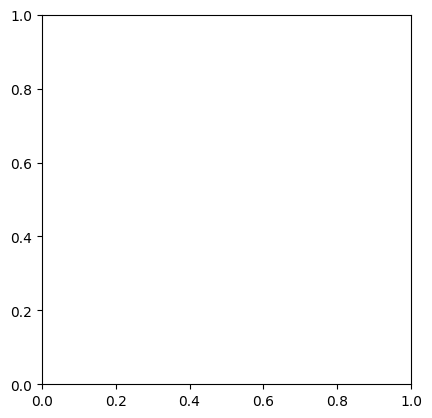

In [ ]:

show()
lbp_feature_extraction(faces_x_bw[0:1])[0]

## SIFT (Scale-Invariant Feature Transform)

http://weitz.de/sift/


https://www.analyticsvidhya.com/blog/2019/10/detailed-guide-powerful-sift-technique-image-matching-python/#:~:text=The%20SIFT%20technique%20involves%20generating,feature%20matching%20and%20object%20recognition.

Inspiration for the implementation:  
https://github.com/Akhilesh64/Image-Classification-using-SIFT/blob/main/main.py

In [ ]:
# function for SIFT-feature extraction
# this returns the 1x128 array descriptors of all found features in the image
def CalcFeatures(img):
  sift = cv2.xfeatures2d.SIFT_create()
  kp, des = sift.detectAndCompute(img, None)
  return des


In [ ]:
# Bag-Of-Features
# now we assign the features of the training data to the clusters they are most
# similar to. In other words: We put each feature into a bag of features.
# We do so using a function
# the function returns a k-long array, giving the number of features that
# each cluster represents in the given features.
# When this function is executed on many features, you get an overview on
# how the clusters are represented.
# When you pass only a single feature, you just get
# its assigned cluster number as an index.
def bag_of_features(features_array, clusters):
  # number of clusters
  k = clusters.shape[0]
  # create a zeros vector, as long as the number of clusters k
  # this will be
  cluster_counter = np.zeros((1, k))
  # iterate through all image features
  for i, feature in enumerate(features_array):
    # get the differences from the current feature to all cluster centres
    differences = np.tile(feature, (k, 1)) - clusters
    # get the euclidian distances -> sqrt(sum(differences squared))
    distances = pow(((pow(differences, 2)).sum(axis=1)), 0.5)
    # get the indices of the sorted distances to get the minimal distance
    index_distances = distances.argsort()
    # get the index of the minimum distance
    index_min_distance = index_distances[0]
    # for the closest cluster, increase the counter by 1
    cluster_counter[0][index_min_distance] += 1
  # return the numbers of assignments to the clusters
  return cluster_counter

# this executes the bag_of_features function, but only for 1 feature
# it returns the index of the assigned cluster
def get_bag_of_feature_assignment(feature, clusters):
  cluster_counter = bag_of_features(np.array([feature]), clusters)
  return np.where(cluster_counter == 1)[1][0]


In [ ]:
# this function uses SIFT-feature extraction to transform 1D-image data

def SIFT_feature_extraction(x_train, y_train, x_test=None, y_test=None, k=200, time_it=True):
  start_time = datetime.now()

  print("SIFT feature extraction starting")
  print("Analysing features of training data")

  # if no separate test has given, we have to make a split later

  # put all feature descriptors of all images in a matrix
  # the matrix has 128 columns and 1 row for each feature of each image
  # e.g. if each of 100 images has 3 features, the matrix will be 300 x 128
  features = []

  # do that only with the training data
  for img in x_train:
    img_des = CalcFeatures(img)
    if img_des is not None:
      features.append(img_des)

  # 1 row per feature, 1 col per feature dimension
  features = np.vstack(features)

  print(f"{features.shape[0]} features keypoints have been found within the {x_train.shape[0]} images.")

  # many the thousands of features in 128 dimensions are very similar
  # also, two nearly identical objects will have some features that are
  # very similar, but not the same.
  # therefore we will create clusters for the features and use them as labels
  # instead of the features themselves
  # the number of clusters is k
  # we use kmeans clustering by cv2

  # stopping criteria: specified accuracy reached or max iterations exceeded
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
  # flags: how are initial centroids placed
  flags = cv2.KMEANS_RANDOM_CENTERS
  # train kmeans clustering on the features' descriptors
  ### tbh. I have no idea what the third parameter does
  ### I copied the code from github, and it had it in there,
  ### the documentation of the function only has 5 arguments listed
  ### but in the documentation they also use 6 arguments in the examples
  print("Finding feature clusters")
  compactness, labels, centres = cv2.kmeans(features, k, None, criteria, 10, flags)
  print("k-means clustering done")
  print("Compactness:", compactness)
  print("There are", centres.shape[0], """cluster centres, described in
  the feature space with""", centres.shape[1], "dimensions.")


  ## Examples:
  ## When the bag_of_features function is executed on many features, you get an overview on
  ## how the clusters are represented.
  #print("Counts of all clusters on all features:\n", bag_of_features(features, centres))
  ## With the get_bag_of_feature_assignment you get only the assigned
  ## cluster number of a single feature
  #print("Assigned cluster of feature number 12:", get_bag_of_feature_assignment(features[12], centres))


  # if test data has not been supplied separately from training data
  # do a split here and now
  if x_test is None or y_test is None:
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train)



  # Transforming the training data
  print("Transforming training data")
  # create a list of labels and a list of cluster counts for the training data
  x_clusters_train = []
  y_sift_train = []
  # iterate through all images again
  # use enumerate, so that we can get the labels too
  for i, img in enumerate(x_train):
    # get the SIFT descriptions of the image
    # this is a matrix with one row per feature and 128 columns
    img_description = CalcFeatures(img)
    if img_description is not None:
      # assign the image descriptor to clusters, get the counts of those assigmnts
      img_clusters = bag_of_features(img_description, centres)
      x_clusters_train.append(img_clusters)
      # save the label of the current image to the labels list
      y_sift_train.append(y_train[i])

  # 1 row per image, k columns, each with the count of features of the image,
  # that have been assigned to this column's cluster
  x_clusters_train = np.vstack(x_clusters_train)



  # Transforming the test data
  print("Transforming test data")
  # create a list of labels and a list of cluster counts for the test data
  y_sift_test = []
  x_clusters_test = []
  # iterate through all images again
  # use enumerate, so that we can get the labels too
  for i, img in enumerate(x_test):
    # get the SIFT descriptions of the image
    # this is a matrix with one row per feature and 128 columns
    img_description = CalcFeatures(img)
    if img_description is not None:
      # assign the image descriptor to clusters, get the counts of those assigmnts
      img_clusters = bag_of_features(img_description, centres)
      x_clusters_test.append(img_clusters)
      # save the label of the current image to the labels list
      y_sift_test.append(y_test[i])

  # 1 row per image, k columns, each with the count of features of the image,
  # that have been assigned to this column's cluster
  x_clusters_test = np.vstack(x_clusters_test)


  time_elapsed = datetime.now() - start_time
  print('SIFT-extraction done — time taken (hh:mm:ss.ms) {}'.format(time_elapsed))

  # return the transformed data
  # if the parameter time_it is true, return the elapsed time as well
  if time_it:
    return x_clusters_train, y_sift_train, x_clusters_test, y_sift_test, time_elapsed
  else:
    return x_clusters_train, y_sift_train, x_clusters_test, y_sift_test




In [ ]:
# Simple SVM — training and testing

# this function trains on input data and returns certain results
# this function uses SVM and returns Balanced Accuracy, weighted F1 and a confusion matrix

def SVM_train_test(x_train, y_train, x_test, y_test, print_results=True, time_it=True):
  start_time = datetime.now()

  # training the classifier
  # as they did in the inspiration repo, we will use SVM
  model = SVC()
  print("Training the SVM model")
  model.fit(x_train, y_train)

  # make predictions on the training data
  print("Making predicions on training data")
  preds = model.predict(x_test)
  # evaluate the test
  acc = balanced_accuracy_score(y_test, preds)
  f1 = f1_score(y_test, preds, average="weighted")
  conf_mat = confusion_matrix(y_test, preds)

  time_elapsed = datetime.now() - start_time
  print('SVM training and testing done — time taken (hh:mm:ss.ms) {}'.format(time_elapsed))


  if print_results:
    print("Balanced ccuracy:", acc)
    print("F1 Score:", f1)
    print(conf_mat)

  # return the transformed data
  # if the parameter time_it is true, return the elapsed time as well
  if time_it:
    return acc, f1, conf_mat, time_elapsed
  else:
    return acc, f1, conf_mat

### Fashion Dataset

In [ ]:
# assign data variables
x_train = fashion_x_train
y_train = fashion_y_train
x_test = fashion_x_test
y_test = fashion_y_test

# do the SIFT feature extractions
x_sift_train, y_sift_train, x_sift_test, y_sift_test = SIFT_feature_extraction(x_train, y_train, x_test, y_test, k=400)

# now train and test a model using the SIFT data
results = SVM_train_test(x_sift_train, y_sift_train, x_sift_test, y_sift_test)


SIFT feature extraction starting
Analysing features of training data
241395 features keypoints have been found within the 60000 images.
Finding feature clusters
k-means clustering done
Compactness: 11019539549.760132
There are 400 cluster centres, described in
  the feature space with 128 dimensions.
Transforming training data
Transforming test data
Training the SVM model
Making predicions on training data
Balanced ccuracy: 0.6266543916422979
F1 Score: 0.6206200579193945
[[606  15  62  67  31  39  62   8  47   7]
 [  3 467  11  91  11  13   8  12  10   2]
 [ 37  14 497  24 197  27 100   4  49   5]
 [ 99  60  70 440  69  32  43  37  67   6]
 [ 18   8 226  38 470  13 129   5  66   0]
 [  9  12   9  21   2 775  14  91   7  26]
 [142  18 181  71 158  25 259   7  62   9]
 [  6  11   6  34   5  46   6 737  18  96]
 [ 24  21  57  48  41  19  41   9 692   6]
 [ 14   0   5  18   6  21   2  77  21 824]]
SIFT feature extraction starting
Analysing features of training data
241395 features keypoint

KeyboardInterrupt: 

In [ ]:
# assign data variables
x_train = fashion_x_train
y_train = fashion_y_train
x_test = fashion_x_test
y_test = fashion_y_test

# extract the features using LBP feature extraction
x_lbp_train = lbp_feature_extraction(x_train, time_it=False)
x_lbp_test = lbp_feature_extraction(x_test, time_it=False)

# now train and test a model using the LBP data
results = SVM_train_test(x_lbp_train, y_train, x_lbp_test, y_test)

Local Binary Patterns feature extraction starting
LBP-extraction done — time taken (hh:mm:ss.ms) 0:00:34.089099
Local Binary Patterns feature extraction starting
LBP-extraction done — time taken (hh:mm:ss.ms) 0:00:06.088969
Training the SVM model
Making predicions on training data
Balanced ccuracy: 0.6026
F1 Score: 0.5930261753524539
[[639   7  71  74  40   5  36   3  78  47]
 [  1 813  13  40   4  68   1  26  30   4]
 [ 17   1 629   7 204   1  74   0  56  11]
 [ 36  42  31 548  58  60  20 117  48  40]
 [ 14   1 233  70 517   5 100   3  54   3]
 [  4 120   4  13   4 665   0 130  19  41]
 [138   8 332  42 185   4 173   2 100  16]
 [  0  39   0  54   0  47   0 787   3  70]
 [ 63  35 137  51  62  26  46  19 487  74]
 [ 46   2   5  57   4   8   2  83  25 768]]


### Faces in the wild

In [ ]:
# assign data variables
x_train = faces_x_bw
y_train = faces_y


# do the SIFT feature extractions
x_sift_train, y_sift_train, x_sift_test, y_sift_test = SIFT_feature_extraction(x_train, y_train, k=400)

# now train and test a model using the SIFT data
results = SVM_train_test(x_sift_train, y_sift_train, x_sift_test, y_sift_test)

NameError: name 'faces_x_bw' is not defined

In [ ]:
# assign data variables
x_train = faces_x_bw
y_train = faces_y
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train)

# extract the features using LBP feature extraction
x_lbp_train = lbp_feature_extraction(x_train, time_it=False)
x_lbp_test = lbp_feature_extraction(x_test, time_it=False)

# now train and test a model using the LBP data
results = SVM_train_test(x_lbp_train, y_train, x_lbp_test, y_test)

Local Binary Patterns feature extraction starting
LBP-extraction done — time taken (hh:mm:ss.ms) 0:03:52.409498
Local Binary Patterns feature extraction starting
LBP-extraction done — time taken (hh:mm:ss.ms) 0:01:15.242728
Training the SVM model
Making predicions on training data
SVM training and testing done — time taken (hh:mm:ss.ms) 0:02:11.680008
Balanced ccuracy: 0.0009775171065493646
F1 Score: 0.00627768261133438
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# CNN

## LeNet
https://www.kaggle.com/code/blurredmachine/lenet-architecture-a-complete-guide

In [ ]:
def build_lenet(input_shape, num_classes, optimizer, loss, metrics):
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the feature maps
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

## MobileNet V2
https://www.tensorflow.org/tutorials/images/transfer_learning \
expects pixel values in [-1, 1]

In [ ]:
def build_mobilenetv2(input_shape, num_classes, optimizer, loss, metrics):
    # Load the pre-trained MobileNetV2 model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    base_model.trainable = False


    # Create a new model on top of the base model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

## Preprocessing for CNN
prefetching?, normalization, data augmentation

### Data Normalisation
MobileNet V2 expects

In [ ]:
def normalize_mobilenet(images):
    # Scale pixel values to the range [-1, 1]
    normalized_images = (images / 127.5) - 1.0
    return normalized_images
def normalize_lenet(images):
    # Scale pixel values to the range [0, 1]
    normalized_images = (images / 255)
    return normalized_images


### Data augmentation